## Classifier Performance Summary
#### Plot to summarise the performance of the different classifiers on BOSS DR12 data
In this notebook, we load the results from all of our classifiers on a subset of the BOSS DR12Q Superset, and compare the results. We look at performance vs redshift, R-band magnitude, and signal-to-noise ratio.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

from quasarnet.io import read_truth
from qn_analysis import plot, utils, variables

In [2]:
figsize = (12,6.5)
fontsize = 18

temp_output_loc = '/global/cfs/projectdirs/desi/users/jfarr/QuasarNET_paper/'

plt.rc('font', size=fontsize)

### Load the results from the different classifiers

In [3]:
## RR parameters

## QN parameters
n_detect = 1
c_th = 0.8
include_c_qn = True

## SQ parameters
p_min = 0.32
include_p_sq = True

In [4]:
f_truth = variables.OUTDIR+'/data/truth/truth_dr12q.fits'
truth = read_truth([f_truth])

In [5]:
data = {}

## Load the RR data.
f_rr = temp_output_loc+'/results/rr_results/rr_sdr12q.fits'
data['RR'] = utils.load_rr_data(f_rr)

## Load the DR12 pipeline data.
f_dr12pipe = temp_output_loc+'/results/dr12pipe_results/dr12pipe_sdr12q.fits'
data['PIPE'] = utils.load_rr_data(f_dr12pipe)

## Load the QN data.
f_qn = temp_output_loc+'/results/qn_results/qn_performance_vs_training_set_size/qn_90pc.fits'
data['QN'] = utils.load_qn_data(f_qn,n_detect=n_detect,c_th=c_th,include_c=include_c_qn)

## Load the SQ data.
f_sq = temp_output_loc+'/results/sq_results/sq_sdr12q.fits'
data['SQ'] = utils.load_sq_data(f_sq,p_min=p_min,include_p=include_p_sq)

### Find the set of common spectra, and reduce all data to that set
This finds which spectra* are common to all datasets, and removes any that are not common. It then matches the data from each classifier to each spectrum, and produces a single data table.

\* using spec_id = plate$\times$1000000000 + mjd$\times$10000 + fiber for BOSS, or spec_id = targetid for DESI (to be updated)

In [6]:
data_table = utils.reduce_data_to_table(data,truth,include_c_qn=include_c_qn,include_p_sq=include_p_sq)
data_table[:5]

INFO: 61729 common spectra


OBJ_ID,SPEC_ID,ZCONF_PERSON,Z_VI,CLASS_VI,ISQSO_VI,Z_RR,Z_PIPE,Z_QN,Z_SQ,CLASS_RR,CLASS_PIPE,CLASS_QN,CLASS_SQ,ISQSO_RR,ISQSO_PIPE,ISQSO_QN,ISQSO_SQ,C_QN [6],P_SQ,ZWARN_RR,ZWARN_PIPE
int64,int64,int64,float64,str8,bool,float64,float64,float64,float64,str8,str8,str8,str8,bool,bool,bool,bool,float64,float64,int64,int64
77823481,3586551810050,2,0.000,STAR,False,-0.000,-0.000,2.039,0.535,STAR,STAR,NONQSO,NONQSO,False,False,False,False,0.000 .. 0.000,0.144,0,0
75657603,3586551810414,2,0.000,STAR,False,0.000,0.000,2.057,0.544,STAR,STAR,NONQSO,NONQSO,False,False,False,False,0.000 .. 0.000,0.316,0,0
96887043,3586551810500,2,0.000,STAR,False,-0.000,-0.000,2.022,0.913,STAR,STAR,NONQSO,NONQSO,False,False,False,False,0.000 .. 0.000,0.209,0,0
106776674,3586551810510,2,0.000,STAR,False,1.532,5.725,1.515,-1.000,GALAXY,QSO,NONQSO,NONQSO,False,True,False,False,0.000 .. 0.000,-1.000,0,4
104298275,3586551810514,1,2.100,QSO,True,1.112,1.111,1.106,0.740,QSO,QSO,QSO,NONQSO,True,True,True,False,0.000 .. 0.000,0.279,0,4


In [7]:
# Include only objects in the data table that have the highest confidence level.
data_table = data_table[data_table['ZCONF_PERSON']==2]
len(data_table)

60375

### Compare the performance of the classifiers.
We would like to show the performance of the different classifiers on a single dataset. We can show purity and completeness vs a range of different quantities.

In [8]:
## Define general parameter values.
dv_max = 6000.

## QN parameters
cth = 0.8
n_detect = 1

## SQ parameters
p_min = 0.32

In [9]:
## Define strategies.
strategies = {}

strategies['RR'] = {'w': data_table['ISQSO_RR'] & (data_table['ZWARN_RR']==0),
                    'z': data_table['Z_RR'],
                    'n': 'redrock',
                    'c': utils.colours['C0'],
                    'ls': '-',
                   }

strategies['PIPE'] = {'w': data_table['ISQSO_PIPE'] & (data_table['ZWARN_PIPE']==0),
                      'z': data_table['Z_PIPE'],
                      'n': 'DR12 Pipeline',
                      'c': utils.colours['C3'],
                      'ls': '--',
                     }

strategies['QN'] = {'w': ((data_table['C_QN']>cth).sum(axis=1)>=n_detect),
                    'confs': (data_table['C_QN']).max(axis=1),
                    'z': data_table['Z_QN'],
                    'n': 'QuasarNET',
                    'c': utils.colours['C1'],
                    'ls': '-.',
                   }

strategies['SQ'] = {'w': (data_table['P_SQ']>p_min),
                    'confs': data_table['P_SQ'],
                    'z': data_table['Z_SQ'],
                    'n': 'SQUEzE',
                    'c': utils.colours['C2'],
                    'ls': ':',
                   }

#### Performance vs redshift

/global/u1/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/astropy/table/column.py:991: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(super(), op)(other)


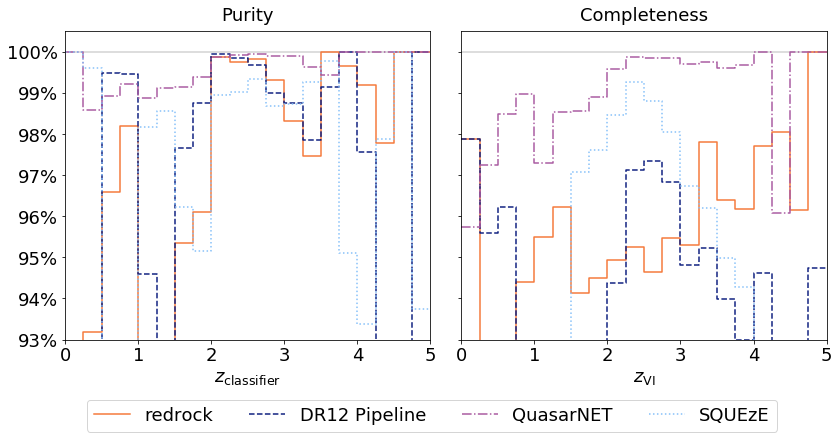

In [10]:
## Plot performance as a function of redshift for our strategies.
zmin = 0.
zmax = 5.
dz_int = 21
filename = '../plots/classifier_performance_summary_altcolour.pdf'

plot.plot_pur_com_vs_z(data_table,strategies,filename=filename,
                       zmin=zmin,zmax=zmax,dz_int=dz_int,dv_max=dv_max,
                       nydec=0,figsize=figsize)

plt.show()

### Performance vs c_th in two redshift bins

/global/u1/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/astropy/table/column.py:991: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(super(), op)(other)


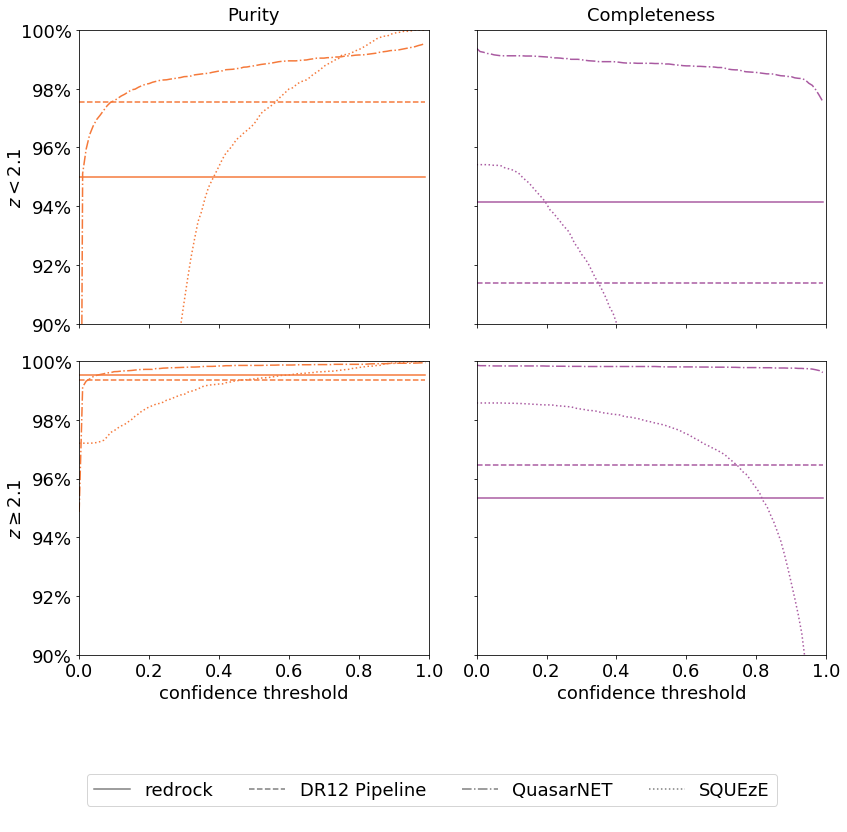

In [11]:
zbins = [(None,2.1),(2.1,None)]
ymin = 0.9
ymax = 1.0
filename = '../plots/classifier_performance_summary_alt.pdf'

plot.plot_pur_com_vs_cth_zbin(data_table,strategies,filename=filename,
                         zbins=zbins,dv_max=dv_max,nydec=0,
                         figsize=(12,12),ymin=ymin,ymax=ymax)

plt.show()

In [12]:
## WIP

/global/u1/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/astropy/table/column.py:991: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(super(), op)(other)


NameError: name 'isqso_c' is not defined

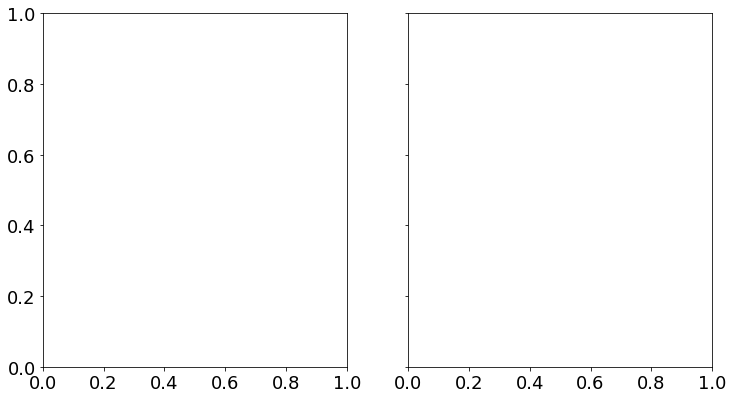

In [13]:
fig, axs = plt.subplots(1,2,figsize=(figsize[0],figsize[1]),sharex=True,sharey=True)

zlya = 2.1

cth_min = 0.0
cth_max = 1.0
n_int = 100
c_th = np.arange(cth_min,cth_max,(1/n_int)*(cth_max-cth_min))
ndetect = 1

isqso_truth = (data_table['ISQSO_VI'] & (data_table['ZCONF_PERSON']==2))
isgal_truth = (data_table['CLASS_VI']=='GALAXY')
isbad = ((data_table['ZCONF_PERSON']=='BAD') | (data_table['ZCONF_PERSON']!=2))
islya = (data_table['Z_VI']>=zlya)

for j,c in enumerate([k for k in data.keys() if k!='RR']):

    for i,wz in enumerate([~islya,islya]):
    
        tpr = []
        fpr = []
    
        z_c = data_table['Z_{}'.format(c)]
        zgood = (data_table['Z_VI']>-1) & (abs(z_c-data_table['Z_VI']) < dv_max*(1+data_table['Z_VI'])/300000.)

        for cth in c_th:
            if c=='QN':
                isqso_c = (data_table['CMAX_{}'.format(c)]>cth)>=ndetect
            elif c=='SQ':
                isqso_c = (data_table['P_{}'.format(c)]>cth)
            elif c=='RR':
                isqso_c = (data_table['ISQSO_{}'.format(c)])

            tp = (isqso_c & (isqso_truth | isgal_truth) & zgood & ~isbad & wz).sum()
            fp = (isqso_c & (~isbad) & wz).sum() - tp
            tn = (~isqso_c & (~isqso_truth) & wz).sum()
            fn = (~isqso_c & isqso_truth & wz).sum()
            
            tpr += [tp/(tp+fn)]
            fpr += [fp/(tn+fp)]
                   
        axs[i].plot(fpr,tpr,color=colours['C0'],ls=ls[c])

for i,wz in enumerate([~islya,islya]):
    isqso_rr = data_table['ISQSO_RR']
    tp = (isqso_rr & (isqso_truth | isgal_truth) & zgood & ~isbad & wz).sum()
    fp = (isqso_rr & (~isbad) & wz).sum() - tp
    tn = (~isqso_rr & (~isqso_truth) & wz).sum()
    fn = (~isqso_rr & isqso_truth & wz).sum()
    tpr = [tp/(tp+fn)]
    fpr = [fp/(tn+fp)]
    print(fp,tn)
    axs[i].scatter(fpr,tpr,color=colours['C0'],ls=ls[c],marker='X')

axs[0].set_title(r'$z_\mathrm{VI}<2.1$')
axs[1].set_title(r'$z_\mathrm{VI}\geq2.1$')

for ax in axs:
    #ax.set_xlim(0.,1.)
    #ax.set_ylim(0.,1.)
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0,decimals=0))
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0,decimals=0))
    ax.set_xlabel(r'false positive rate')

axs[0].set_ylabel(r'true positive rate')

artists = []
labels = []
for j,c in enumerate(data.keys()):
    artists += [axs[0].step([0],[0],where='pre',color='grey',ls=ls[c])[0]]
    labels += [legend_name[c]]

fig.legend(artists,labels,loc='lower center',borderaxespad=0,bbox_to_anchor=(0.5,0.03),ncol=len(artists))
rect = (0,0.13,1.,1.)
plt.tight_layout(rect=rect)
#plt.margins(x=0.1,y=0.1)

plt.savefig('../plots/classifier_performance_summary_alt2.pdf')
plt.show()